## **Importing Modules**

In [1]:
#importing required modules

import gdown
import zipfile
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import torchvision.models as models
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets, transforms as T

import os
import torch.optim as optim
from PIL import ImageFile

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, roc_curve


## **Data Preprocessing**

In [2]:
#importing data

#Dataset address
url = 'https://drive.google.com/uc?export=download&id=1B75cOYH7VCaiqdeQYvMuUuy_Mn_5tPMY'
output = 'data.zip'
gdown.download(url, output, quiet=False)

#giving zip file name
data_dir='./data.zip'

#extractng data from zip file
with zipfile.ZipFile(data_dir, 'r') as zf:
    zf.extractall('./data')
    print('Done downloading and extraction')

#removing zip file after extraction
!rm './data.zip' 

#invstigating number of files
orange_files = np.array(glob("/content/data/*/*/*"))
print('There are %d total chest xray images.' % len(orange_files))

#checking the availability of a GPU
use_cuda = torch.cuda.is_available()

Downloading...
From: https://drive.google.com/uc?export=download&id=1B75cOYH7VCaiqdeQYvMuUuy_Mn_5tPMY
To: /content/data.zip
100%|██████████| 46.1M/46.1M [00:00<00:00, 86.7MB/s]


Done downloading and extraction
There are 4626 total chest xray images.


In [3]:
#declaring batch size
batch_size = 32

#applying required transformations on the dataset
img_transforms = {
    'train':
    T.Compose([
        T.Resize(size=(224,224)), 
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]), 
         
    ]),
    

    'valid':
    T.Compose([
        T.Resize(size=(224,224)),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),


    'test':
    T.Compose([
        T.Resize(size=(224,224)),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}


#  creating Location of data: train, validation, test
orange_file='./data/'

train_path=os.path.join(orange_file,'train')
valid_path=os.path.join(orange_file,'test')
test_path=os.path.join(orange_file,'valid')


# creating Datasets to each of  folder created in prev
train_file=datasets.ImageFolder(train_path,transform=img_transforms['train'])
valid_file=datasets.ImageFolder(valid_path,transform=img_transforms['valid'])
test_file=datasets.ImageFolder(test_path,transform=img_transforms['test'])


#Creating loaders for the dataset
loaders_transfer={
    'train':torch.utils.data.DataLoader(train_file,batch_size,shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_file,batch_size,shuffle=True),
    'test': torch.utils.data.DataLoader(test_file,batch_size,shuffle=True)
}

## **Model Building**

In [4]:
#importing the pretrained AlexNet model

model_transfer = models.alexnet(pretrained=True)

# Freeze weights
for param in model_transfer.features.parameters():
    param.requires_grad = False

# Defining Dense top layers after the convolutional layers
model_transfer.classifier= nn.Sequential(
    nn.Linear(in_features=9216, out_features=1024),
    nn.LeakyReLU(inplace = True),
          
    nn.Linear(1024,256),
    nn.LeakyReLU(inplace=True),
    nn.Linear(256,32),
    nn.LeakyReLU(inplace=True),
    nn.Linear(32,2),
    nn.Sigmoid()

    )
if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [5]:
model_transfer

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01, 

In [6]:
# Plotting the summary of the model

summary(model_transfer, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [7]:
# selecting loss function
criterion_transfer = nn.CrossEntropyLoss()

#using Adam classifier
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.0005,weight_decay=1e-5)

## **Training and Validating the Model**



In [9]:

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Creating the function for training
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    trainingloss = []
    validationloss = []

    for epoch in range(1, n_epochs+1):
        # initialize the variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        correct1 = 0.
        total1 = 0.
        correct2 = 0.
        total2 = 0.

        ###################
        # training the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
          
            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
           
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions
            correct1 += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total1 += data.size(0)

       
        ######################    
        # validating the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions
            correct2 += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total2 += data.size(0)

      

        train_loss = train_loss/len(train_file)
        valid_loss = valid_loss/len(valid_file)

        trainingloss.append(train_loss)
        validationloss.append(valid_loss)
        acc1 = 100. * correct1 / total1
        acc2 =  100. * correct2 / total2
        # printing training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.4f}'.format(
            epoch,
            train_loss,
            acc1,
            valid_loss,
            acc2
            ))
        
        ## saving the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            
            valid_loss_min = valid_loss
            
    # return trained model
    return model, trainingloss, validationloss

In [10]:
# training the model

n_epochs=50

model_transfer, train_loss, valid_loss = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 0.000107 	Training Accuracy: 91.7612 	Validation Loss: 0.000799 	Validation Accuracy: 94.3723
Validation loss decreased (inf --> 0.000799).  Saving model ...
Epoch: 2 	Training Loss: 0.000092 	Training Accuracy: 96.9206 	Validation Loss: 0.000742 	Validation Accuracy: 96.5368
Validation loss decreased (0.000799 --> 0.000742).  Saving model ...
Epoch: 3 	Training Loss: 0.000090 	Training Accuracy: 98.0821 	Validation Loss: 0.000736 	Validation Accuracy: 96.9697
Validation loss decreased (0.000742 --> 0.000736).  Saving model ...
Epoch: 4 	Training Loss: 0.000092 	Training Accuracy: 97.2988 	Validation Loss: 0.000786 	Validation Accuracy: 94.8052
Epoch: 5 	Training Loss: 0.000091 	Training Accuracy: 97.4608 	Validation Loss: 0.000725 	Validation Accuracy: 97.6190
Validation loss decreased (0.000736 --> 0.000725).  Saving model ...
Epoch: 6 	Training Loss: 0.000090 	Training Accuracy: 98.0821 	Validation Loss: 0.000726 	Validation Accuracy: 97.6190
Epoch: 7 	Train

In [11]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

##  **Testing the Model**



In [12]:
# Defining the test function

def test(loaders, model, criterion, use_cuda):

    # monitoring test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    preds = []
    targets = []

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # moving to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # updating average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # converting the output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        preds.append(pred)
        targets.append(target)
        # compare predictions
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    
    return preds, targets

# calling test function
preds, targets = test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

## **Visulizing the results**

In [13]:
#converting the tensor object to a list for metric functions

preds2, targets2 = [],[]

for i in preds:
  for j in range(len(i)):
    preds2.append(i.cpu().numpy()[j])
for i in targets:
  for j in range(len(i)):
    targets2.append(i.cpu().numpy()[j])

Confusion Matrix:
 [[228   6]
 [  3 225]]


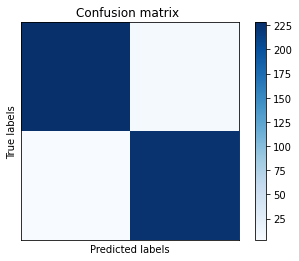

In [14]:
#plotting the confusion matrix for testing data

cm = confusion_matrix(preds2, targets2)
print('Confusion Matrix:\n', cm)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

AUC score:  0.9805194805194806
Accuracy:  0.9805194805194806
F1 score:  0.9803921568627451
Precision score:  0.9868421052631579
Recall score:  0.974025974025974


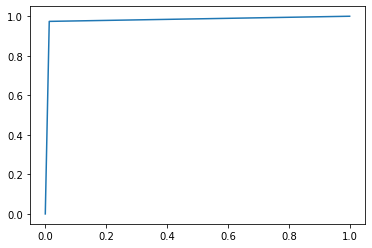

In [15]:
#Computing the 5 evaluation metrics and printing

acc = accuracy_score(targets2, preds2)

fpr, tpr, _ = roc_curve(targets2, preds2)

area = roc_auc_score(targets2, preds2)
print("AUC score: ", area)

print("Accuracy: ", acc)

f1 = f1_score(targets2, preds2)
print("F1 score: ", f1)

pre = precision_score(targets2, preds2)
print("Precision score: ", pre)

recall = recall_score(targets2, preds2)
print("Recall score: ", recall)

plt.plot(fpr, tpr)

Text(0, 0.5, 'loss')

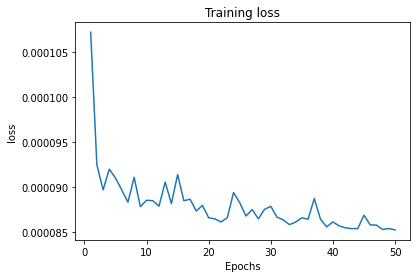

In [16]:
#Plotting the training loss

plt.plot(range(1,51),train_loss)
plt.title("Training loss")
plt.xlabel('Epochs')
plt.ylabel("loss")

Text(0, 0.5, 'loss')

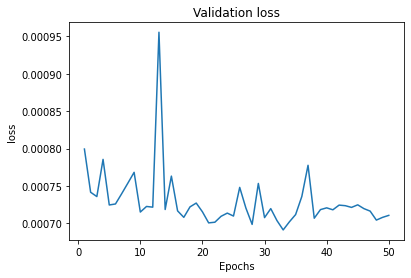

In [17]:
#Plotting the validation loss

plt.plot(range(1,1+n_epochs),valid_loss)
plt.title("Validation loss")
plt.xlabel('Epochs')
plt.ylabel("loss")